## This notebook provide the instructions on how to read the data from the cloud using OpenVisus framework.

### To run this notebook properly, you need to install the library `OpenVisus`. To install this, please run the following command from your terminal:
`pip install OpenVisus`

# **Step 1: Importing the libraries**

In [1]:
import numpy as np
import os
os.environ["VISUS_CACHE"]="./visus_cache_can_be_erased"
from OpenVisus import *
import matplotlib.pyplot as plt
import time
start_time = time.time()

### The section below shows different LLC2160 fields we have available in cloud. Each field is >200TB.

In [2]:
eastwest_ocean_velocity_u="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_arco/visus.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
northsouth_ocean_velocity_v="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_v/v_llc2160_x_y_depth.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
vertical_velocity_w="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_w/llc2160_w.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
temperature_theta="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_theta/llc2160_theta.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
Salinity_salt="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_salt/salt_llc2160_x_y_depth.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"


In [3]:
!python --version

Python 3.9.13


## **Step 2: Reading the metadata file from cloud**
In this section, you can select any variables that you can declared in the cells above and replace it inside `LoadDataset`. We are just reading the metadata for the dataset here.

In [4]:
db=LoadDataset(Salinity_salt)
print(f'Dimensions: {db.getLogicBox()[1][0]}*{db.getLogicBox()[1][1]}*{db.getLogicBox()[1][2]}')
print(f'Total Timesteps: {len(db.getTimesteps())}')
print(f'Field: {db.getField().name}')
print('Data Type: float32')

Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: salt
Data Type: float32


## **Step 3:  Data Selection**
This section shows you how to load the data you want. You can select any timestep, region (x,y,z) you want. You can set the quality or resolution of the data as well. Higher quality means the finer(more) data. Not setting any time means first timestep available. Not setting quality means full data which takes a while to load because of the higher filesize. 

In [5]:
# here you can select the resoution at which you query the data: -15 is very coarse, 0 is full resoltuon (dangerous since you may fetch a lot of data and wait a long time).
data_resolution = -9 # try values among -15, -12, -9, -6, -3, 0
data3D=db.read(time=0,quality=data_resolution)
print(data3D.shape)
print(np.min(data3D),np.max(data3D))

(12, 810, 1080)
0.0 50.94112


## **Step 4:  Visualize the data**
We are using a simple matplotlib here, but since the data is in numpy array, it can loaded with any python modules that support numpy. Feel free to set the `vmin`,`vmax` appropriately.

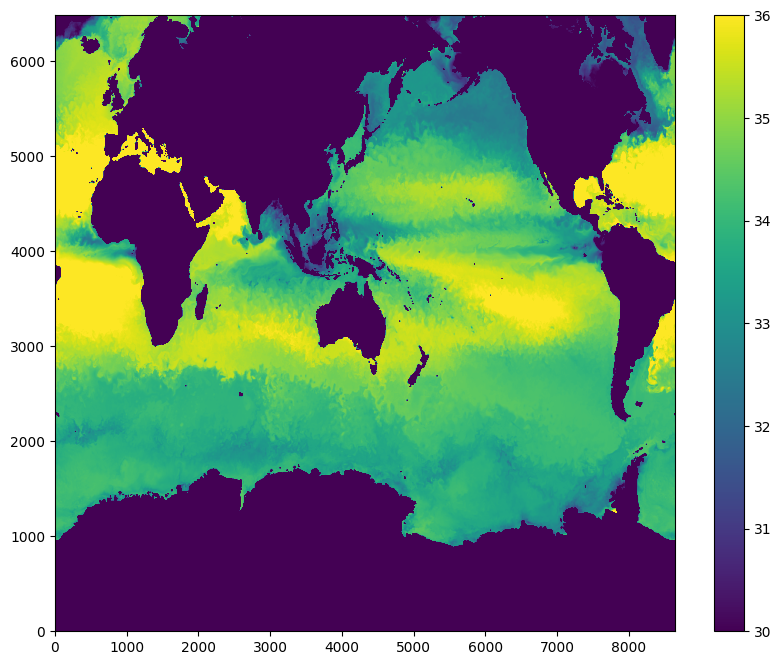

In [12]:
# 
depth = 0  #between 0 and 89
depth = int(depth  /db.getLogicBox()[1][2] *data3D.shape[0])
data = data3D[depth,:,:]
fig,axes=plt.subplots(1,1,figsize=(10,8))
axes.set_xlim(0,8640)
axes.set_ylim(0,6480)
axp = axes.imshow(data,extent=[0,8640,0,6480], aspect='auto',origin='lower',vmin=30,vmax=36,cmap='viridis')
plt.colorbar(axp,location='right')
plt.show()

### Testing Salinity examples 

In [16]:
min_salinity = 34
max_salinity = 35.9

data_land = np.where(data ==0   , 1, 0)
data_restricted = np.where(data > min_salinity   , data, 0)
data_restricted = np.where(data_restricted < max_salinity  , data_restricted, 0)



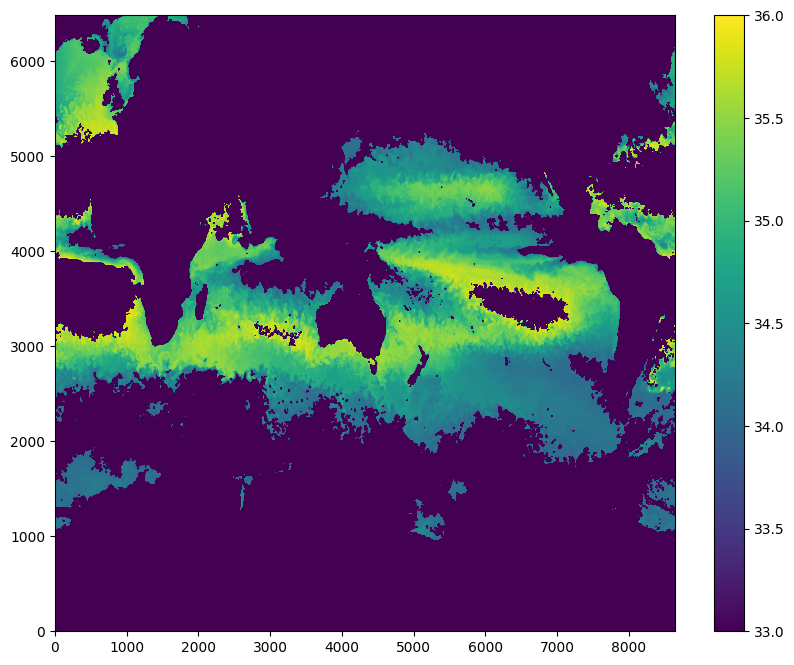

In [17]:
fig,axes=plt.subplots(1,1,figsize=(10,8))
axes.set_xlim(0,8640)
axes.set_ylim(0,6480)
axp = axes.imshow(data_restricted,extent=[0,8640,0,6480], aspect='auto',origin='lower',vmin=33,vmax=36,cmap='viridis')
plt.colorbar(axp,location='right')
plt.show()

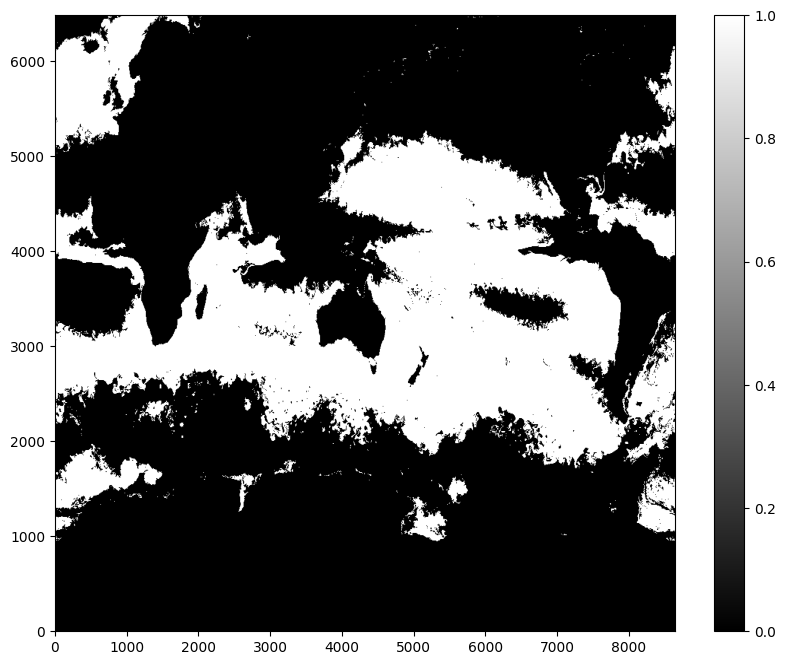

In [18]:
data_binary = np.where(data_restricted >  0  , 1 , 0)
fig,axes=plt.subplots(1,1,figsize=(10,8))
axes.set_xlim(0,8640)
axes.set_ylim(0,6480)
axp = axes.imshow(data_binary,extent=[0,8640,0,6480], aspect='auto',origin='lower',vmin=0,vmax=1,cmap='gray')
plt.colorbar(axp,location='right')
plt.show()

## **Calculate the percentage of voxels within the selected salinity range**


In [19]:
total_voxels = data.shape[0] * data.shape[1]  
land_voxels  = np.sum(data_land)
white_voxels = np.sum(data_binary)
print("Test at data resolution ", data_resolution)
print (total_voxels,land_voxels, white_voxels)
print("percentage of land voxels", '{:.2%}'.format(land_voxels/total_voxels))
print("percentage of world voxels within the salinity range", '{:.2%}'.format(white_voxels/(total_voxels)))
print("percentage of water voxels within the salinity range", '{:.2%}'.format(white_voxels/(total_voxels-land_voxels)))
end_time= time.time()
print(f'Execution time: {end_time - start_time:.2f} seconds')

Test at data resolution  -9
874800 380479 261747
percentage of land voxels 43.49%
percentage of world voxels within the salinity range 29.92%
percentage of water voxels within the salinity range 52.95%
Execution time: 93.72 seconds


## **Results on valerio's desktop at home**

Test at data resolution  0 (I would not try this!!!!) <br>
55987200 24342221 16750511 <br>
percentage of land voxels 43.48% <br>
percentage of world voxels within the salinity range 29.92% <br>
percentage of water voxels within the salinity range 52.93% <br>
Execution time: 1016.64 seconds <br>


Test at data resolution  -3 <br>
13996800 6086076 4187586 <br>
percentage of land voxels 43.48% <br>
percentage of world voxels within the salinity range 29.92%<br>
percentage of water voxels within the salinity range 52.94%  <br>
Execution time: 128.61 seconds (13.97 seconds with cache)<br>

Test at data resolution  -6  <br>
3499200 1521669 1046818 <br>
percentage of land voxels 43.49% <br>
percentage of world voxels within the salinity range 29.92%<br>
percentage of water voxels within the salinity range 52.94% <br>
Execution time: 16.96 seconds (3.29 seconds with cache)<br>
<br>
Test at data resolution  -15  <br>
54810 23921 16356 <br>
percentage of land voxels 43.64% <br>
percentage of world voxels within the salinity range 29.84% <br>
percentage of water voxels within the salinity range 52.95% <br>
Execution time: 1.57 seconds (1.19 seconds with cache) <br>

## **But, what if you want to see the full data for a certain region at a certain depth?**
Just set the right x,y,z while reading the data. x and y are the bounding box, z is the depth/layer. 

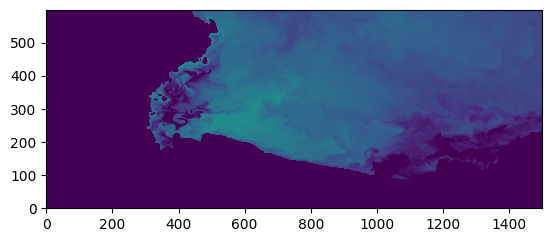

In [20]:
data1=db.read(time=0,z=[0,1],x=[4500,6000],y=[800,1400])
plt.imshow(data1[0,:,:], origin='lower',vmin=33,vmax=36,cmap='viridis')

# **Try the same calculation on the region of interest**
Exercise for the user :-)


### *Please reach out to Aashish Panta, Giorgio Scorzelli or Valerio Pascucci for any concerns about the notebook. Thank you!*
- Aashish Panta (aashishpanta0@gmail.com)
- Giorgio Scorzelli (scrgiorgio@gmail.com)
- Valerio Pascucci (pascucci.valerio@gmail.com)